# Lab Assignment 7: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa, Van Tran

## Preparation

This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a young person would spend money on gadgets. 

We wanted to find a classifer that would interest advertisers. Many of the questions asked here may not be something readily available or something that can be scraped from social media. These include phobias and spending habits that aren't the likeliness of spending money on gadgets.

### Define and prepare class variables

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

target_classifier = 'Spending on gadgets'
df = pd.read_csv('responses.csv', sep=",")
desired_features = ["Music","Dance","Folk","Country","Classical music","Musical",
    "Pop","Rock","Metal or Hardrock","Punk","Hiphop, Rap","Reggae, Ska",
    "Swing, Jazz","Rock n roll","Alternative","Latino","Techno, Trance",
    "Opera","Movies","Horror","Thriller","Comedy","Romantic","Sci-fi","War",
    "Fantasy/Fairy tales","Animated","Documentary","Western","Action","History",
    "Psychology","Politics","Mathematics","Physics","Internet","PC","Economy Management",
    "Biology","Chemistry","Reading","Geography","Foreign languages","Medicine","Law",
    "Cars","Art exhibitions","Religion","Countryside, outdoors","Dancing",
    "Musical instruments","Writing","Passive sport","Active sport","Gardening","Celebrities",
    "Shopping","Science and technology","Theatre","Fun with friends","Adrenaline sports",
    "Pets","Smoking","Alcohol","Healthy eating","Spending on gadgets","Age","Height","Weight",
    "Number of siblings","Gender","Left - right handed","Education","Village - town","House - block of flats"
]

df = df[desired_features]
df.head()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


,Music,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,...,Spending on gadgets,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Village - town,House - block of flats
0,5.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,...,1,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,village,block of flats
1,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,...,5,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,city,block of flats
2,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,...,4,20.0,176.0,67.0,2.0,female,right handed,secondary school,city,block of flats
3,5.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,...,4,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,city,house/bungalow
4,5.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,...,2,20.0,170.0,59.0,1.0,female,right handed,secondary school,village,house/bungalow


The list above is our desired attributes. We are not including phobias, spending habits (that aren't spending on gadgets), being an only child (as number of siblins answers the same question), and views on life and opinions (we thought that the questions asked would not be indicative of data that would be scraped.

In [8]:
df.rename(columns={'Reggae, Ska': 'ReggaeSka', 'Swing, Jazz': 'SwingJazz', 'Classical music': 'Classicalmusic', 'Metal or Hardrock': 'MetalorHardrock', 'Hiphop, Rap': 'HiphopRap', 'Rock n roll': 'Rocknroll', 'Techno, Trance': 'TechnoTrance', 'Sci-fi': 'Scifi', 'Fantasy/Fairy tales': 'Fantasy', 'Economy Management': 'EconomyManagement', 'Foreign languages': 'Foreignlanguages', 'Art exhibitions': 'Artexhibitions', 'Countryside, outdoors': 'outdoors', 'Musical instruments': 'Musicalinstruments', 'Passive sport': 'Passivesport', 'Active sport': 'Activesport', 'Science and technology': 'Scienceandtechnology', 'Fun with friends': 'Funwithfriends', 'Adrenaline sports': 'Adrenalinesports', 'Healthy eating': 'Healthyeating', 'Spending on gadgets': 'Spendingongadgets', 'Number of siblings': 'Numberofsiblings', 'Left - right handed': 'Leftrighthanded', 'Village - town': 'Villagetown', 'House - block of flats': 'Houseblockofflats'}, inplace=True)

We are renaming some columns so they can work with Tensor Flow.

In [9]:
from copy import deepcopy
df_train = deepcopy(df)
df_test = deepcopy(df)

In [11]:
# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,Music,Dance,Folk,Country,Classicalmusic,Musical,Pop,Rock,MetalorHardrock,Punk,...,Spendingongadgets,Age,Height,Weight,Numberofsiblings,Gender,Leftrighthanded,Education,Villagetown,Houseblockofflats
0,5.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,...,1,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,village,block of flats
1,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,...,5,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,city,block of flats
2,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,...,4,20.0,176.0,67.0,2.0,female,right handed,secondary school,city,block of flats
3,5.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,...,4,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,city,house/bungalow
4,5.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,...,2,20.0,170.0,59.0,1.0,female,right handed,secondary school,village,house/bungalow


In [5]:
categorical_headers = list(df.select_dtypes(include=['object']).columns)
numeric_headers = list(df.select_dtypes(include=['float']).columns) + list(df.select_dtypes(include=['int']).columns)

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = dict() 

for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=='Spendingongadgets':
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

print(numeric_headers)
for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

['Music', 'Dance', 'Folk', 'Country', 'Classicalmusic', 'Musical', 'Pop', 'Rock', 'MetalorHardrock', 'Punk', 'HiphopRap', 'ReggaeSka', 'SwingJazz', 'Rocknroll', 'Alternative', 'Latino', 'TechnoTrance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Scifi', 'War', 'Fantasy', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'EconomyManagement', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreignlanguages', 'Medicine', 'Law', 'Cars', 'Artexhibitions', 'Religion', 'outdoors', 'Dancing', 'Musicalinstruments', 'Writing', 'Passivesport', 'Activesport', 'Gardening', 'Celebrities', 'Shopping', 'Scienceandtechnology', 'Theatre', 'Funwithfriends', 'Adrenalinesports', 'Pets', 'Healthyeating', 'Age', 'Height', 'Weight', 'Numberofsiblings', 'Spendingongadgets']


### Evaluating our Algorithm's Performance

In [7]:
cost_matrix = np.matrix([
[0,1,2],
[1,0,1],
[3,1,0],
])

def get_confusion_costTot(confusion_matrix, cost_matrix, num_X):
    score = np.sum(confusion_matrix*cost_matrix)/num_X
    return score

confusion_scorer = make_scorer(get_confusion_costTot, greater_is_better=False)
confusion_scorer

make_scorer(get_confusion_costTot, greater_is_better=False)

___

![tf](https://wiki.tum.de/download/attachments/25009442/tensor-flow_opengraph_h.png?version=1&modificationDate=1485888308193&api=v2)

# Starting Tensorflow
Now that we have processed the data, let's grab numpy matrices of the features we would like to predict with. In particular, we will convert everything to 32 bits (as a lot of Tensorflow is written with this arch in mind). 

In [8]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['Spendingongadgets'].values.astype(np.int)
y_test = df_test['Spendingongadgets'].values.astype(np.int)

print(feature_columns)

['Smoking_int', 'Alcohol_int', 'Gender_int', 'Leftrighthanded_int', 'Education_int', 'Villagetown_int', 'Houseblockofflats_int', 'Music', 'Dance', 'Folk', 'Country', 'Classicalmusic', 'Musical', 'Pop', 'Rock', 'MetalorHardrock', 'Punk', 'HiphopRap', 'ReggaeSka', 'SwingJazz', 'Rocknroll', 'Alternative', 'Latino', 'TechnoTrance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Scifi', 'War', 'Fantasy', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'EconomyManagement', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreignlanguages', 'Medicine', 'Law', 'Cars', 'Artexhibitions', 'Religion', 'outdoors', 'Dancing', 'Musicalinstruments', 'Writing', 'Passivesport', 'Activesport', 'Gardening', 'Celebrities', 'Shopping', 'Scienceandtechnology', 'Theatre', 'Funwithfriends', 'Adrenalinesports', 'Pets', 'Healthyeating', 'Age', 'Height', 'Weight', 'Numberofsiblings', 'Spendingongadgets']


Now let's import the tensorflow contrib libraries. These libraries are the workhorses for tensorflow's simplified interface. Please note that this was previously called "SKFlow" and might one day be replaced by the simplified syntax of Keras. Keras will received native TF support and be included in tf.contrib but as of the creation of this notebook, that is not the case. As such, we will be using syntax for the contrib library as of Rev 1.0 of tensorflow. 

- Please also note that keras is getting added to the core tensorflow contribution library such that this command will work:
 - `from tensorflow.contrib import keras`
- As such, if you want to use the Keras API, it will soon be supported! Even so, its unclear what syntax changes and additions will be made to the existing Keras tools, so we will forge ahead using the "learn" API

When using the learn API, we will still be using many of the native tensorflow functions, so we 
- `import tensorflow as tf` to get access to the entire API when needed
- `from tensorflow.contrib import learn` to get access to many of the wrappers and simplifications for using tensorflow. This library really helps with creating models and using some out-of-the-box networks (like a shallow/deep MLP with fully connected layers)
- `from tensorflow.contrib import layers` will be used to get access to some common neural network layer types and activations 
- `from tensorflow.contrib.learn.python import SKCompat` this will be used to give us a very familir interface as used in sklearn.

In [9]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

![tflearn](http://www.kdnuggets.com/wp-content/uploads/skflow.jpg)

## An example similar to Sklearn
We will start with creating a model that is similar to what we have seen in scikit-learn. 

In [10]:
%%time
# we need to tell tensorflow how many inputs to expect and what the data types will be
# for this early example, everything is just numeric, real valued
features_tf = [layers.real_valued_column('', dimension=X_train.shape[1])]
clf = SKCompat(# wrap with SKCompat for easy usage like sklearn
            learn.DNNClassifier(hidden_units=[50], feature_columns=features_tf)
        )

clf.fit(X_train,y_train,steps=100)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
CPU times: user 5.62 s, sys: 91.3 ms, total: 5.71 s
Wall time: 5.65 s


In [11]:
yhat = clf.predict(X_test)
# notice that the output needs some interpretation
# as its not completely the same as sklearn
yhat = yhat['classes']
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 136   0]
 [  0 483  43]
 [  0  33  77]] 25.3866666667


In [12]:
%%time
# we can also custimize the classifier somewhat:
clf = SKCompat(# wrap with SKCompat for easy usage like sklearn
            learn.DNNClassifier(hidden_units=[50], 
                                feature_columns=features_tf,
                                activation_fn=tf.nn.sigmoid 
                                # tf.tanh, tf.sigmoid, tf.nn.relu, tf.nn.softmax etc.
                                )
        )

clf.fit(X_train,y_train,steps=1000)

yhat = clf.predict(X_test)['classes']
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
[[  0 136   0]
 [  0 522   4]
 [  0  15  95]] 24.5466666667
CPU times: user 7.58 s, sys: 436 ms, total: 8.02 s
Wall time: 7.18 s


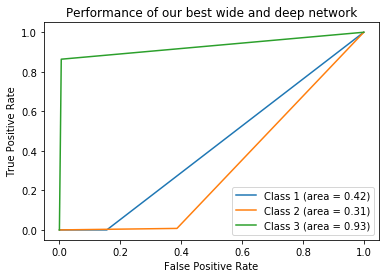

In [13]:
# graphing ROC
aucs = []
fprs = []
tprs = []

ind_yhat = yhat
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     yhat,
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))
plt.figure()
plt.title("Performance of our best wide and deep network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for i in range(0,3):
    plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
               % (i+1, aucs[i]))
    plt.legend(loc='best')

plt.show()

___
## Adding more customization
This type of architecture is fine to use, but suffers from many limitations: if its not implemented by the `learn` API, then we can't use the architecture or customize it easily. To get around this, we, instead, will use the `Estimator` class. To use this class, we need to define a "model function" that creates the neural network architecture. The output of this model needs to be very specific: a three tuple of 
- (1) predictions in a format that the end user will need to use
- (2) loss function implemented as tf graph 
- (3)  the optimization operation to perform on the graph. 

For this particular optimization, let's go beyond SGD and use Adagrad. There are many excellent explanations of different optimizers, for instance:
- http://sebastianruder.com/optimizing-gradient-descent/

There is a lot of code here that might be new, but essentially we are starting to get down to the core functionality of tensorflow (even though still using the learn API).

In [14]:

# let's start by just using the tflearn library out of the box on the data we have
def my_model(features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function, but could also choose 
        # cross entropy, or other objective functions here
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions=predictions_out, loss=loss_mse, train_op=train_op)


Now that we have defined the model, its as simple as using it in a very familiar syntax:

In [15]:
%%time

from sklearn.metrics import confusion_matrix, accuracy_score

# now let train the estimator
# we can wrap the tf estimator in the SKCompat class
# so that we can use similar syntax to to SKLearn 
clf = SKCompat(learn.Estimator(model_fn=my_model))
clf.fit(X_train, y_train, steps=5000, batch_size=32)

yhat = clf.predict(X_test)
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 136   0]
 [  0 514  12]
 [  0   5 105]] 25.2666666667
CPU times: user 10.6 s, sys: 1.77 s, total: 12.3 s
Wall time: 9.19 s


___

### Note [start review here]

## Handling different feature types

You may have noticed that we were not handling the categorical features correctly. Really we need to one hot encode the categorical features
unfortunately, this requires using part of the API that breaks some conventions of SKLearn. In this example, we will use the integer categorical labels to get one hot encoded examples.

The advantage of this method is that we can write our custom preprocessing steps and use them straight in the pipeline of the classifier. However, the syntax for this is verbose and fairly ugly. So, let's get started!

First, we need a process input function that performs all the tensoflow preparation of the data and returns a dictionary of the name and values of each feature column. It should also return the target column as a tf.constant

In [16]:
# Let's start with the TF example (manipulated to work with new syntax)
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.expand_dims( # make it a column vector
                            tf.cast( # cast to a float32
                                tf.constant(df[k].values), 
                                tf.float32), 
                            1)
                       for k in numeric_headers}
    
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored as constant Tensors (numeric)
    # then use tensor flow to one hot encode them using the given number of classes 
    # name of encoder is **_int need to map only to **
    categorical_cols = {k: tf.one_hot(indices=tf.constant(df[k].values),
                                      depth=len(encoders[k[:-4]].classes_)) 
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label


Now, when we want to use the classifier, we tell the model how it needs to parse the inputs. For each numeric feature, we simply need to convert the tensors into column vectors (see below). For the categrocial vectors, TF has a convenient "one_hot" function that we can use. The remainder of the model selection stays the same. 

In [17]:
# update the model to take input features as a dictionary
def my_model(dict_features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    #=======DECODE FEATURES================
    # now let's combine the tensors from the input dictionary
    # into a list of the feature columns
    features = []
    #features = [dict_features[x] for x in numeric_headers+categorical_headers_ints]
    for col in numeric_headers:
        features.append(dict_features[col])
    
    # also add in the one hot encoded features
    for col in categorical_headers_ints:
        features.append(dict_features[col])
    
    # now we can just combine all the features together
    features = tf.concat(values=features,axis=1)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important 
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions={'incomes':predictions_out}, loss=loss_mse, train_op=train_op)

Now to call the estimator with our custom pre-processing step we need to wrap the preprocessing inside another function. This is easy to do with a simple lambda, but you could also use another wrapper function that takes no inputs. 

In [18]:
%%time
clf = learn.Estimator(model_fn=my_model)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=
        lambda:process_input(df_train,'Spendingongadgets',categorical_headers_ints, numeric_headers), 
        steps=500)

CPU times: user 6.28 s, sys: 265 ms, total: 6.55 s
Wall time: 5.6 s


In [19]:
yhat = clf.predict(input_fn=
                   lambda:process_input(df_test,None,categorical_headers_ints, numeric_headers))
# the output is now an iterable value, so we need to step over it
yhat = [x['incomes'] for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_test.shape[1]))

[[  0 136   0]
 [  0 383 143]
 [  0   0 110]] 30.7066666667


In [20]:
# Now lets create a wide model 
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.constant(df[k].values) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label


In [21]:
# update the model to take input features as a dictionary
def setup_wide_columns():
    # let's create the column structure that the learn API can expect
    
    wide_columns = []
    # add in each of the categorical columns
    for col in categorical_headers:
        wide_columns.append(layers.sparse_column_with_keys(col, keys=encoders[col].classes_))
        
    # also add in some specific crossed columns
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
                        
    return wide_columns

In [22]:
print(categorical_headers)
print(numeric_headers)

['Smoking', 'Alcohol', 'Gender', 'Leftrighthanded', 'Education', 'Villagetown', 'Houseblockofflats']
['Music', 'Dance', 'Folk', 'Country', 'Classicalmusic', 'Musical', 'Pop', 'Rock', 'MetalorHardrock', 'Punk', 'HiphopRap', 'ReggaeSka', 'SwingJazz', 'Rocknroll', 'Alternative', 'Latino', 'TechnoTrance', 'Opera', 'Movies', 'Horror', 'Thriller', 'Comedy', 'Romantic', 'Scifi', 'War', 'Fantasy', 'Animated', 'Documentary', 'Western', 'Action', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics', 'Internet', 'PC', 'EconomyManagement', 'Biology', 'Chemistry', 'Reading', 'Geography', 'Foreignlanguages', 'Medicine', 'Law', 'Cars', 'Artexhibitions', 'Religion', 'outdoors', 'Dancing', 'Musicalinstruments', 'Writing', 'Passivesport', 'Activesport', 'Gardening', 'Celebrities', 'Shopping', 'Scienceandtechnology', 'Theatre', 'Funwithfriends', 'Adrenalinesports', 'Pets', 'Healthyeating', 'Age', 'Height', 'Weight', 'Numberofsiblings', 'Spendingongadgets']


In [23]:
%%time

# ignore all the deprecations that the learn API needs to deal with... ugh
tf.logging.set_verbosity(tf.logging.ERROR)

# setup 
wide_columns = setup_wide_columns()
input_wrapper = lambda:process_input(df_train,'Spendingongadgets',categorical_headers, numeric_headers)
output_wrapper = lambda:process_input(df_test,None,categorical_headers, numeric_headers)

clf = learn.LinearClassifier(feature_columns=wide_columns)

# when we provide the process function, they expect us to control the mini-batch
clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 134   2]
 [  0 515  11]
 [  0 103   7]] 21.3866666667
CPU times: user 22.4 s, sys: 1.1 s, total: 23.5 s
Wall time: 22 s


Wow! That is just using crossed columns and a one layer Linear Classifer! So memorization works fairly well here. 

Now let's try a deeper architecture with dense embeddings for the categorical features, as described in lecture.

___

## Using Dense embeddings in a deeper network

In [24]:
# update the model to take input features as a dictionary
def setup_deep_columns():
    # now make up the deep columns
    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        
        tmp = layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        
        deep_columns.append(
            layers.embedding_column(tmp, dimension=8)
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return deep_columns

In [25]:
%%time 

# setup deep columns
deep_columns = setup_deep_columns()
clf = learn.DNNClassifier(feature_columns=deep_columns, hidden_units=[100, 50])

clf.fit(input_fn=input_wrapper, steps=300)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 135   1]
 [  0 516  10]
 [  0  97  13]] 21.5466666667
CPU times: user 27.1 s, sys: 1.16 s, total: 28.3 s
Wall time: 24.9 s


So the DNN with feature embeddings is also fairly capable (best thus far). For the final example, lets combine the classifiers together like we talked about in lecture.
___

## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier which is already implemented! `learn.DNNLinearCombinedClassifier`

In [26]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns():
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [27]:
%%time

wide_columns, deep_columns = setup_wide_deep_columns()
clf = learn.DNNLinearCombinedClassifier(
                        linear_feature_columns=wide_columns,
                        dnn_feature_columns=deep_columns,
                        dnn_hidden_units=[100, 50])


clf.fit(input_fn=input_wrapper, steps=2500)

yhat = clf.predict(input_fn=output_wrapper)
# the output is now an iterable value, so we need to step over it
yhat = [x for x in yhat]
conf_m = mt.confusion_matrix(y_test,yhat)
print(conf_m,
      get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 136   0]
 [  0 511  15]
 [  0  89  21]] 22.0266666667
CPU times: user 59.8 s, sys: 7.17 s, total: 1min 6s
Wall time: 48.9 s


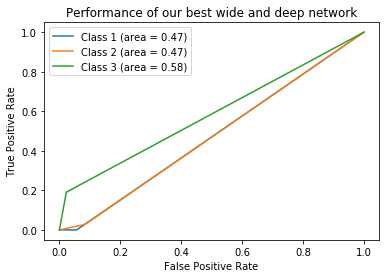

In [28]:
# graphing ROC
aucs = []
fprs = []
tprs = []

ind_yhat = yhat
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)
    # get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     yhat,
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))
plt.figure()
plt.title("Performance of our best wide and deep network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for i in range(0,3):
    plt.plot(fprs[i],tprs[i],label='Class %d (area = %0.2f)'
               % (i+1, aucs[i]))
    plt.legend(loc='best')

plt.show()

### Finding most important cross features
We will be doing this by creating models that each omit one of the cross features. The larger the drop in score tells us the more important the cross feature actually is.

In [35]:
def setup_wide_deep_columns(cross_columns):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_headers:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=encoders[col].classes_)
        )
        
        dim = round(np.log2(len(encoders[col].classes_)))
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=encoders[tup[0]].classes_),
                 layers.sparse_column_with_keys(tup[1], keys=encoders[tup[1]].classes_)],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in numeric_headers:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [36]:
for i in range(3):
    cross_columns = [('Smoking','Alcohol'), ('Villagetown', 'Houseblockofflats'), ('Villagetown', 'Education')]
    cross_columns.remove(cross_columns[i])
    wide_columns, deep_columns = setup_wide_deep_columns(cross_columns)
    clf = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50])


    clf.fit(input_fn=input_wrapper, steps=2500)

    yhat = clf.predict(input_fn=output_wrapper)
    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]
    conf_m = mt.confusion_matrix(y_test,yhat)
    print(conf_m,
          get_confusion_costTot(conf_m, cost_matrix, X_train.shape[1]))

[[  0 136   0]
 [  0 506  20]
 [  0  89  21]] 22.2266666667
[[  0 136   0]
 [  0 509  17]
 [  0  89  21]] 22.1066666667
[[  0 136   0]
 [  0 516  10]
 [  0  92  18]] 21.7066666667


In the above code, we removed each cross product feature individually and trained a model to find it's score. The model with the removed cross product feature that has the higher score means that the cross product feature is more important. Therefore

('Smoking', 'Alcohol') is our most important cross feature
('Villagetown', 'Education') is our next most important cross feature
('Villagetown', 'Houseblockofflats') was our least important cross feature